In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install matplotlib
# !pip install helpers

# !pip install imbalanced-learn

# !pip install tensorflow

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#### Data Loading

In [3]:
# Load the dataset
df = pd.read_csv('data/SAML-D.csv')

In [ ]:
df.shape

(9504852, 12)

In [ ]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [ ]:
df.describe(include='all')

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
count,9504852,9504852,9.504852e+06,9.504852e+06,9.504852e+06,9504852,9504852,9504852,9504852,9504852,9.504852e+06,9504852
unique,86400,321,NaN,NaN,NaN,13,13,18,18,7,NaN,28
top,15:22:42,2023-02-09,NaN,NaN,NaN,UK pounds,UK pounds,UK,UK,Credit card,NaN,Normal_Small_Fan_Out
freq,201,36645,NaN,NaN,NaN,9099293,8783655,9183088,8864634,2012909,NaN,3477717
mean,NaN,NaN,5.006619e+09,5.006006e+09,8.762968e+03,NaN,NaN,NaN,NaN,NaN,1.038733e-03,NaN
std,NaN,NaN,2.885814e+09,2.884763e+09,2.561495e+04,NaN,NaN,NaN,NaN,NaN,3.221263e-02,NaN
min,NaN,NaN,9.018000e+03,9.018000e+03,3.730000e+00,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,2.513133e+09,2.513219e+09,2.143688e+03,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,NaN,5.001017e+09,5.002572e+09,6.113720e+03,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,NaN,7.505051e+09,7.502397e+09,1.045846e+04,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


In [ ]:
df.isnull().sum()

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64

In [ ]:
# # Visualize the distribution of Target Variable
# sns.countplot(data=df, x='Is_laundering')
# plt.title('Distribution of Money Laundering Transactions')
# plt.show()

In [ ]:
# Distribution of Target Variable
df['Is_laundering'].value_counts(normalize=True) * 100

Is_laundering
0    99.896127
1     0.103873
Name: proportion, dtype: float64

In [ ]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

#### Data Cleaning

In [ ]:
df.dtypes

Time                       object
Date                       object
Sender_account              int64
Receiver_account            int64
Amount                    float64
Payment_currency           object
Received_currency          object
Sender_bank_location       object
Receiver_bank_location     object
Payment_type               object
Is_laundering               int64
Laundering_type            object
dtype: object

In [5]:
# Convert Date and Time to appropriate fromats
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

#### Feature Extraction

In [6]:
# Extracting Date Features
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_week'] = df['Date'].dt.day_of_week

# Extracting Time Features
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour

In [7]:
# Create cyclical features for time (hour of day, day of week, etc.)

# Hour of day as cyclical feature
df['hour_sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
df['hour_cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

df['day_sin'] = np.sin(df['Day_of_week'] * (2 * np.pi / 7))
df['day_cos'] = np.cos(df['Day_of_week'] * (2 * np.pi / 7))

# Convert sine/cosine features to float32
for col in ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']:
    df[col] = df[col].astype(np.float32)

In [8]:
cols_to_drop = ['Time', 'Date']
df = df.drop(columns=cols_to_drop)

In [9]:
set(df['Payment_currency'] ) == set(df['Received_currency'])

True

In [10]:
# Define the exchange rates to USD
exchange_rates = {
    'UK pounds': 1.30,
    'Euro': 1.10,
    'Turkish lira': 0.035,
    'Swiss franc': 1.10,
    'Dirham': 0.27,
    'Pakistani rupee': 0.0055,
    'Naira': 0.0022,
    'US dollar': 1.00,
    'Yen': 0.0088,
    'Moroccan dirham': 0.11,
    'Mexican Peso': 0.050,
    'Albanian lek': 0.0095,
    'Indian rupee': 0.012
}

In [11]:
# Ensure the Payment Type does not have any leading/trailing zeroes
df['Payment_currency'] = df['Payment_currency'].str.strip()

# Standardizing the amount by convert Transaction amount to USD
df['Amount_USD'] = df.apply(lambda row: row['Amount'] * exchange_rates.get(row['Payment_currency'], 1), axis = 1)

In [12]:
# Drop Laundering_type to prevent data leakage
df = df.drop(['Amount', 'Laundering_type'], axis=1)

In [ ]:
df.head()

,Sender_account,Receiver_account,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,DateTime,Month,Day,Day_of_week,Hour,hour_sin,hour_cos,day_sin,day_cos,Amount_USD
0,8724731955,2769355426,UK pounds,UK pounds,UK,UK,Cash Deposit,0,2022-10-07 10:35:19,10,7,4,10,0.5,-0.866025,-0.433884,-0.900969,1896.895
1,1491989064,8401255335,UK pounds,Dirham,UK,UAE,Cross-border,0,2022-10-07 10:35:20,10,7,4,10,0.5,-0.866025,-0.433884,-0.900969,7825.532
2,287305149,4404767002,UK pounds,UK pounds,UK,UK,Cheque,0,2022-10-07 10:35:20,10,7,4,10,0.5,-0.866025,-0.433884,-0.900969,18626.972
3,5376652437,9600420220,UK pounds,UK pounds,UK,UK,ACH,0,2022-10-07 10:35:21,10,7,4,10,0.5,-0.866025,-0.433884,-0.900969,15463.500
4,9614186178,3803336972,UK pounds,UK pounds,UK,UK,Cash Deposit,0,2022-10-07 10:35:21,10,7,4,10,0.5,-0.866025,-0.433884,-0.900969,149.825


#### Feature Engineering

In [13]:
# Group by sender account to find patterns
sender_stats = df.groupby('Sender_account').agg({
    'Amount_USD': ['mean', 'std', 'min', 'max', 'count'],
    'Is_laundering': 'mean'  # Percentage of suspicious transactions
}).reset_index()

# Flatten the multi-level column names
sender_stats.columns = ['Sender_account', 'sender_amount_mean', 'sender_amount_std', 
                        'sender_amount_min', 'sender_amount_max', 'sender_tx_count', 
                        'sender_suspicious_ratio']

# Group by receiver account to find patterns
receiver_stats = df.groupby('Receiver_account').agg({
    'Amount_USD': ['mean', 'std', 'min', 'max', 'count'],
    'Is_laundering': 'mean'
}).reset_index()

# Flatten the multi-level column names
receiver_stats.columns = ['Receiver_account', 'receiver_amount_mean', 'receiver_amount_std', 
                         'receiver_amount_min', 'receiver_amount_max', 'receiver_tx_count', 
                         'receiver_suspicious_ratio']

In [14]:
# Merge back to main dataframe
df = df.merge(sender_stats, on='Sender_account', how='left')
df = df.merge(receiver_stats, on='Receiver_account', how='left')

In [ ]:
# Checking for NULL values -- Std can be NULL if there is only 1 transaction
df.isnull().sum()

Sender_account                   0
Receiver_account                 0
Payment_currency                 0
Received_currency                0
Sender_bank_location             0
Receiver_bank_location           0
Payment_type                     0
Is_laundering                    0
DateTime                         0
Month                            0
Day                              0
Day_of_week                      0
Hour                             0
hour_sin                         0
hour_cos                         0
day_sin                          0
day_cos                          0
Amount_USD                       0
sender_amount_mean               0
sender_amount_std            27816
sender_amount_min                0
sender_amount_max                0
sender_tx_count                  0
sender_suspicious_ratio          0
receiver_amount_mean             0
receiver_amount_std          92413
receiver_amount_min              0
receiver_amount_max              0
receiver_tx_count   

In [ ]:
# Fill NaN values
for col in ['sender_amount_std','receiver_amount_std']:
    df[col].fillna(0, inplace=True)

In [16]:
# Convert features dtypes
for col in df.columns:
    if df[col].dtype == 'float64':
        #print(col)
        df[col] = df[col].astype(np.float32)
    elif df[col].dtype == 'int64':
        #print(col)
        df[col] = df[col].astype(np.int32)

In [17]:
# One-hot encode remaining categorical variables
categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
                    'Receiver_bank_location', 'Payment_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
df_encoded.head()

,Sender_account,Receiver_account,Is_laundering,DateTime,Month,Day,Day_of_week,Hour,hour_sin,hour_cos,...,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card
0,134797363,-1525611870,0,2022-10-07 10:35:19,10,7,4,10,0.5,-0.866025,...,False,False,True,False,True,False,False,False,False,False
1,1491989064,-188679257,0,2022-10-07 10:35:20,10,7,4,10,0.5,-0.866025,...,False,True,False,False,False,False,False,False,True,False
2,287305149,109799706,0,2022-10-07 10:35:20,10,7,4,10,0.5,-0.866025,...,False,False,True,False,False,False,True,False,False,False
3,1081685141,1010485628,0,2022-10-07 10:35:21,10,7,4,10,0.5,-0.866025,...,False,False,True,False,False,False,False,False,False,False
4,1024251586,-491630324,0,2022-10-07 10:35:21,10,7,4,10,0.5,-0.866025,...,False,False,True,False,True,False,False,False,False,False


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 89 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   Sender_account                      int32         
 1   Receiver_account                    int32         
 2   Is_laundering                       int32         
 3   DateTime                            datetime64[ns]
 4   Month                               int32         
 5   Day                                 int32         
 6   Day_of_week                         int32         
 7   Hour                                int32         
 8   hour_sin                            float32       
 9   hour_cos                            float32       
 10  day_sin                             float32       
 11  day_cos                             float32       
 12  Amount_USD                          float32       
 13  sender_amount_mean                  float3

In [ ]:
df_encoded.shape

(9504852, 89)

C:\Users\mohee\AppData\Local\Temp\ipykernel_29056\78900669.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Is_laundering', ax=axs1[0, 0], palette='Set2')
C:\Users\mohee\AppData\Local\Temp\ipykernel_29056\78900669.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Is_laundering', y='Amount_USD', ax=axs1[1, 1], palette='coolwarm')


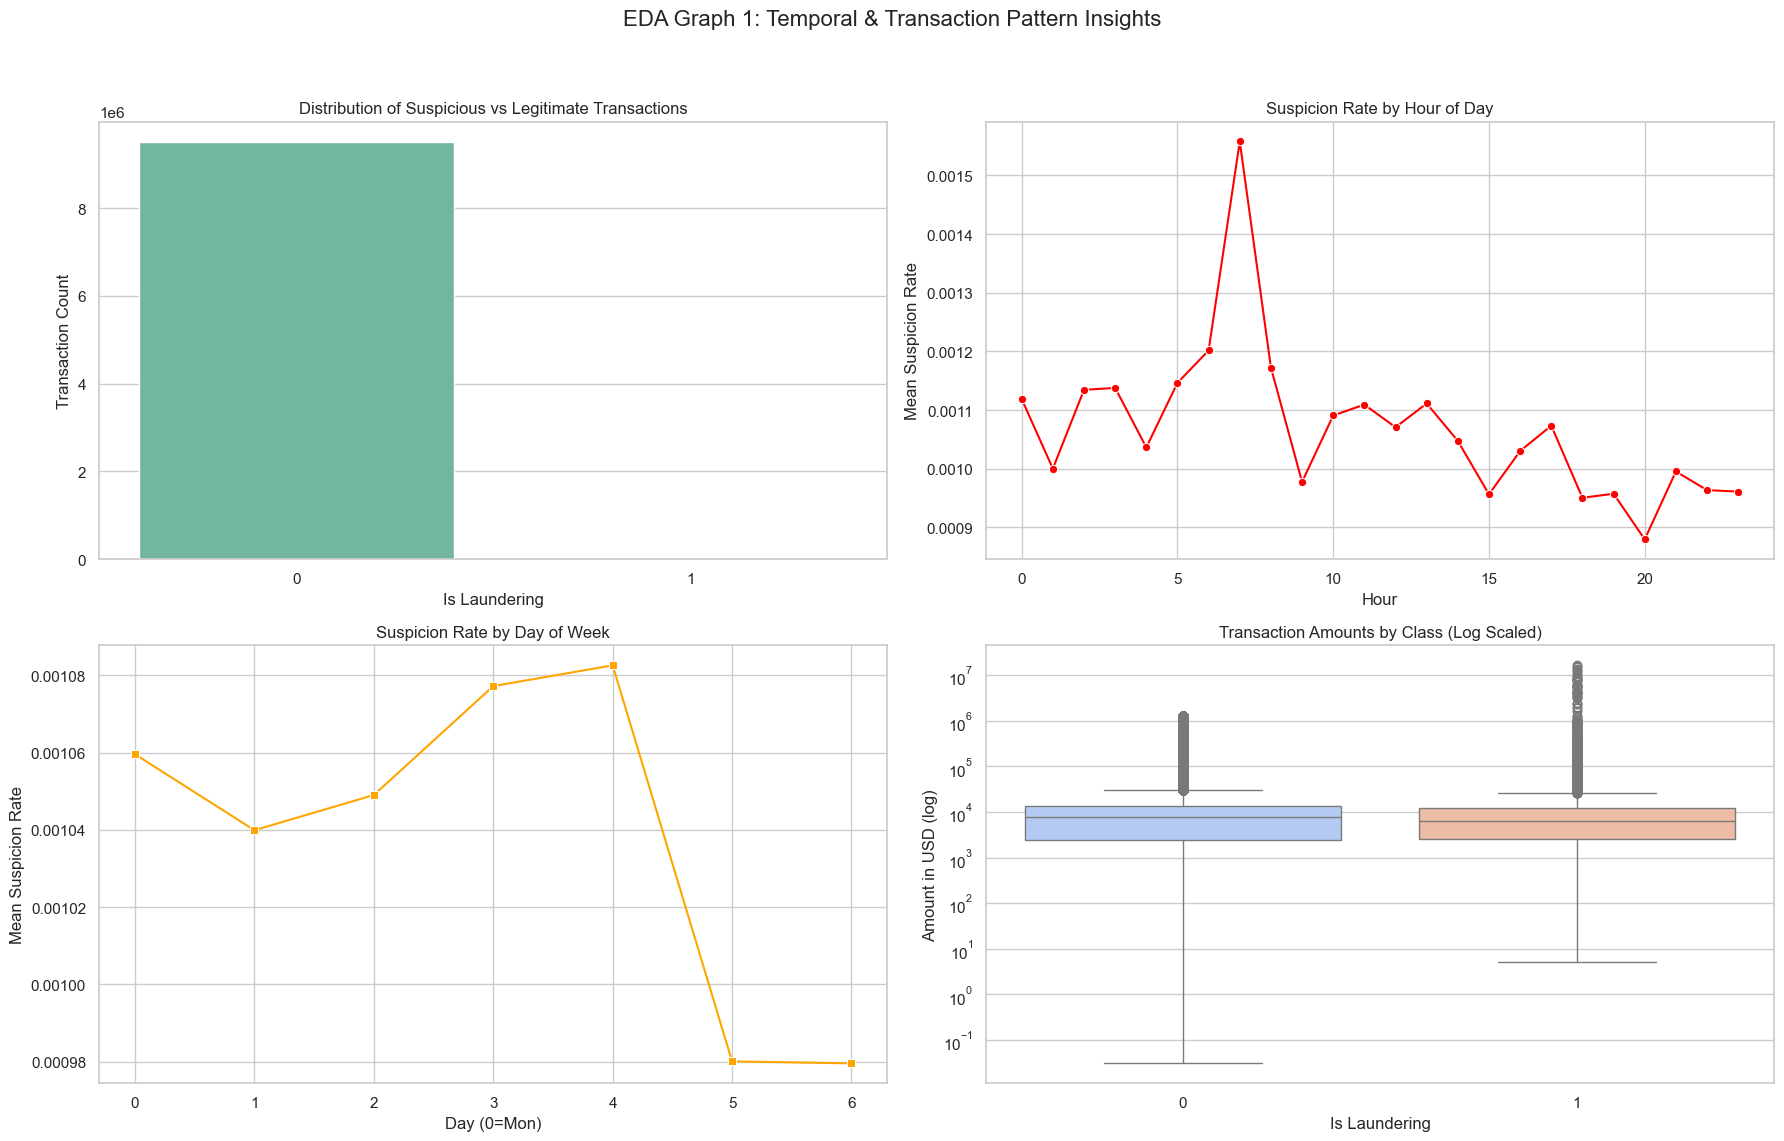

C:\Users\mohee\AppData\Local\Temp\ipykernel_29056\78900669.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sender_loc.values, y=sender_loc.index, ax=axs2[0, 0], palette='Blues_r')
C:\Users\mohee\AppData\Local\Temp\ipykernel_29056\78900669.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=receiver_loc.values, y=receiver_loc.index, ax=axs2[0, 1], palette='Purples_r')
C:\Users\mohee\AppData\Local\Temp\ipykernel_29056\78900669.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pay_type.values, y=pay_type.index, ax=axs2[1, 0], pal

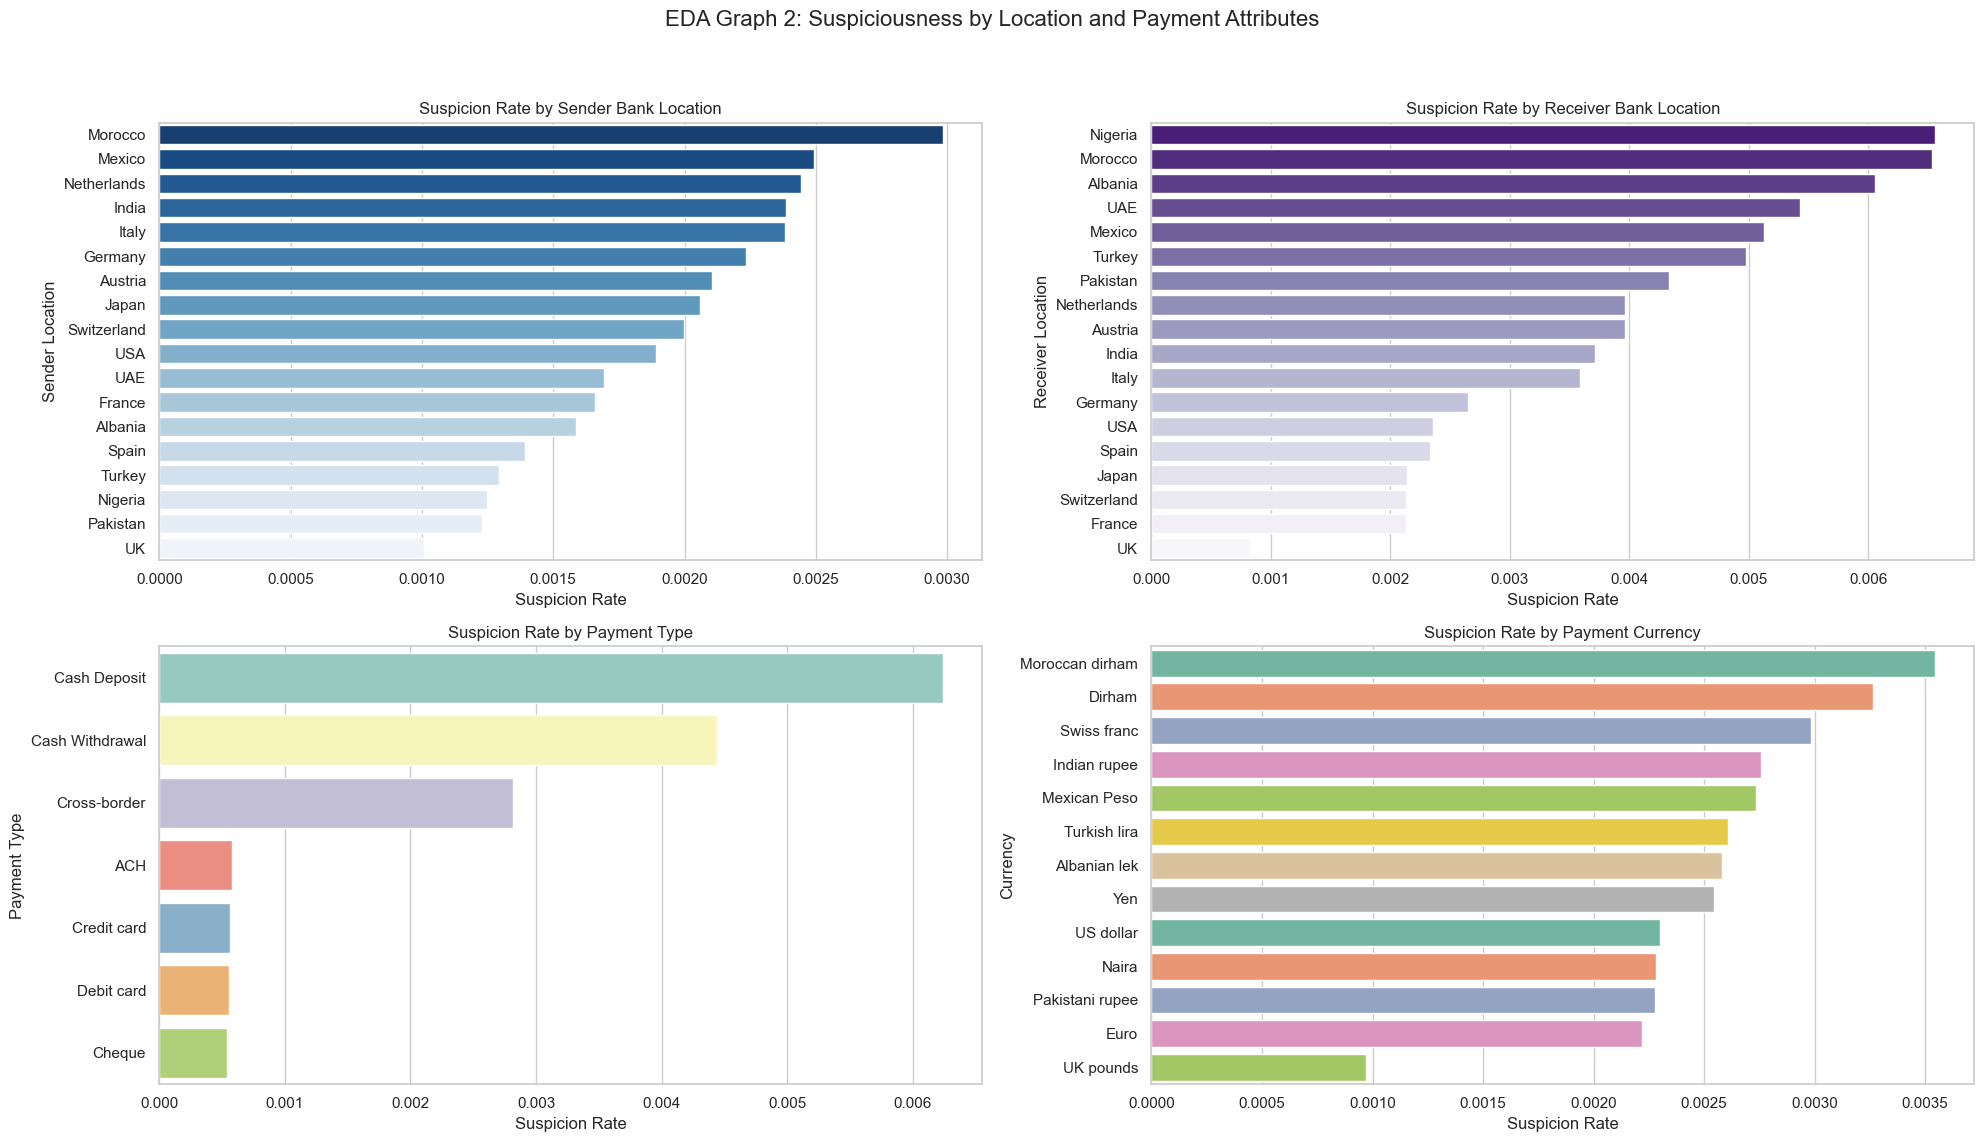

In [ ]:


# Ensure proper styling
sns.set(style="whitegrid")

# ========== Assumes 'df' is your cleaned dataframe ==========

# Graph 1: Class Distribution, Temporal Patterns, and Amount Analysis
fig1, axs1 = plt.subplots(2, 2, figsize=(18, 12))
fig1.suptitle('EDA Graph 1: Temporal & Transaction Pattern Insights', fontsize=16)

# 1. Class Distribution
sns.countplot(data=df, x='Is_laundering', ax=axs1[0, 0], palette='Set2')
axs1[0, 0].set_title('Distribution of Suspicious vs Legitimate Transactions')
axs1[0, 0].set_xlabel('Is Laundering')
axs1[0, 0].set_ylabel('Transaction Count')

# 2. Suspiciousness by Hour
hourly = df.groupby('Hour')['Is_laundering'].mean()
sns.lineplot(x=hourly.index, y=hourly.values, ax=axs1[0, 1], marker='o', color='red')
axs1[0, 1].set_title('Suspicion Rate by Hour of Day')
axs1[0, 1].set_xlabel('Hour')
axs1[0, 1].set_ylabel('Mean Suspicion Rate')

# 3. Suspiciousness by Day of Week
dow = df.groupby('Day_of_week')['Is_laundering'].mean()
sns.lineplot(x=dow.index, y=dow.values, ax=axs1[1, 0], marker='s', color='orange')
axs1[1, 0].set_title('Suspicion Rate by Day of Week')
axs1[1, 0].set_xlabel('Day (0=Mon)')
axs1[1, 0].set_ylabel('Mean Suspicion Rate')

# 4. Amount Distribution by Class
sns.boxplot(data=df, x='Is_laundering', y='Amount_USD', ax=axs1[1, 1], palette='coolwarm')
axs1[1, 1].set_yscale('log')
axs1[1, 1].set_title('Transaction Amounts by Class (Log Scaled)')
axs1[1, 1].set_xlabel('Is Laundering')
axs1[1, 1].set_ylabel('Amount in USD (log)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Graph 2: Geographic & Categorical Suspicion Insights
fig2, axs2 = plt.subplots(2, 2, figsize=(20, 12))
fig2.suptitle('EDA Graph 2: Suspiciousness by Location and Payment Attributes', fontsize=16)

# 1. Sender Bank Location
sender_loc = df.groupby('Sender_bank_location')['Is_laundering'].mean().sort_values(ascending=False)
sns.barplot(x=sender_loc.values, y=sender_loc.index, ax=axs2[0, 0], palette='Blues_r')
axs2[0, 0].set_title('Suspicion Rate by Sender Bank Location')
axs2[0, 0].set_xlabel('Suspicion Rate')
axs2[0, 0].set_ylabel('Sender Location')

# 2. Receiver Bank Location
receiver_loc = df.groupby('Receiver_bank_location')['Is_laundering'].mean().sort_values(ascending=False)
sns.barplot(x=receiver_loc.values, y=receiver_loc.index, ax=axs2[0, 1], palette='Purples_r')
axs2[0, 1].set_title('Suspicion Rate by Receiver Bank Location')
axs2[0, 1].set_xlabel('Suspicion Rate')
axs2[0, 1].set_ylabel('Receiver Location')

# 3. Payment Type
pay_type = df.groupby('Payment_type')['Is_laundering'].mean().sort_values(ascending=False)
sns.barplot(x=pay_type.values, y=pay_type.index, ax=axs2[1, 0], palette='Set3')
axs2[1, 0].set_title('Suspicion Rate by Payment Type')
axs2[1, 0].set_xlabel('Suspicion Rate')
axs2[1, 0].set_ylabel('Payment Type')

# 4. Payment Currency
currency = df.groupby('Payment_currency')['Is_laundering'].mean().sort_values(ascending=False)
sns.barplot(x=currency.values, y=currency.index, ax=axs2[1, 1], palette='Set2')
axs2[1, 1].set_title('Suspicion Rate by Payment Currency')
axs2[1, 1].set_xlabel('Suspicion Rate')
axs2[1, 1].set_ylabel('Currency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Model Implementation

##### Sequential Neural Network Model

In [18]:
# Data Preparation
print("Preparing data for Sequential Neural Network...")
X = df_encoded.drop(['Is_laundering', 'DateTime'], axis=1)
y = df_encoded['Is_laundering']

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Handle class imbalance
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)
print(f"Training set shape after resampling: {X_train_resampled.shape}")
print(f"Class distribution after resampling: {np.bincount(y_train_resampled)}")

# Scale features
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train_resampled)
X_val_scaled = scaler_nn.transform(X_val)
X_test_scaled = scaler_nn.transform(X_test)

Preparing data for Sequential Neural Network...
Training set: 5702910 samples
Validation set: 1900971 samples
Test set: 1900971 samples


d:\Learning\Deep Learning\Project\AML_Prediction\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Learning\Deep Learning\Project\AML_Prediction\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\mohee\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mohee\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

Training set shape after resampling: (1709094, 87)
Class distribution after resampling: [1139396  569698]


In [ ]:

# Model Architecture optimized for precision and recall
print("Building Sequential Neural Network model")
model_nn = Sequential([
    # Increase capacity of first layer
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Lighter regularization
    BatchNormalization(),  # Helps with stable training
    Dropout(0.3),  # Reduced dropout for better information flow
    
    # Stronger middle layer
    Dense(32, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Simpler regularization
    BatchNormalization(),
    Dropout(0.2),  # Reduced dropout
    
    # Additional layer for more representation power
    Dense(16, activation='relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Model Compilation with precision/recall focus
model_nn.compile(
    optimizer=Adam(learning_rate=0.001),  # More stable learning rate
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='ROC', name='auc'),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


model_nn.summary()

# Model Training
print("Training Sequential Neural Network...")
early_stopping_nn = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history_nn = model_nn.fit(
    X_train_scaled, y_train_resampled,
    epochs=5,
    batch_size=256,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping_nn],
    verbose=1
)


Building Sequential Neural Network model...
Building Sequential Neural Network model with improved precision and recall...


d:\Learning\Deep Learning\Project\AML_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,705 (34.00 KB)

 Trainable params: 8,481 (33.13 KB)

 Non-trainable params: 224 (896.00 B)

Training Sequential Neural Network...
Epoch 1/5
6677/6677 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9793 - auc: 0.9933 - loss: 0.2091 - pr_auc: 0.9897 - precision: 0.9690 - recall: 0.9704 - val_accuracy: 0.9991 - val_auc: 0.9812 - val_loss: 0.0181 - val_pr_auc: 0.8532 - val_precision: 0.5387 - val_recall: 0.8815
Epoch 2/5
6677/6677 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9968 - auc: 0.9995 - loss: 0.0254 - pr_auc: 0.9993 - precision: 0.9962 - recall: 0.9942 - val_accuracy: 0.9994 - val_auc: 0.9858 - val_loss: 0.0161 - val_pr_auc: 0.8661 - val_precision: 0.6853 - val_recall: 0.8668
Epoch 3/5
6677/6677 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9968 - auc: 0.9995 - loss: 0.0243 - pr_auc: 0.9993 - precision: 0.9964 - recall: 0.9939 - val_accuracy: 0.9989 - val_auc: 0.9924 - val_loss: 0.0167 - val_pr_auc: 0.7887 - val_precision: 0.4868 - val_recall: 0.8992
Epoch 4/5
6677/6677 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9968 - auc: 0.9995 - loss: 0.0239 - pr_auc: 0.99

Evaluating Sequential Neural Network...


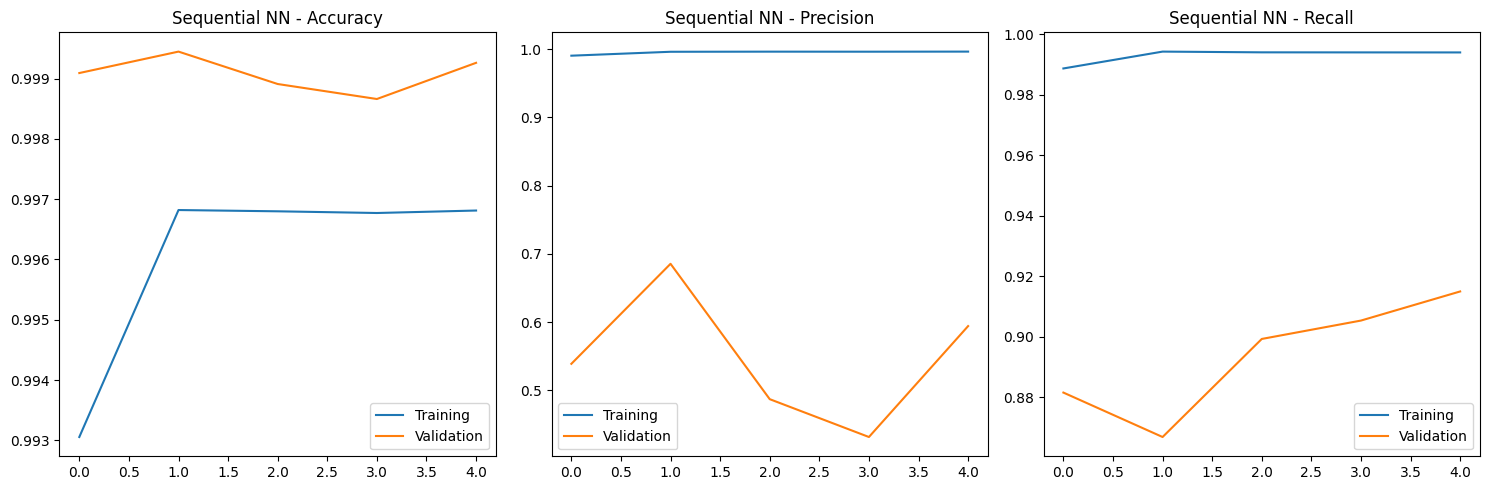


Validation Metrics - Sequential NN:
Accuracy: 0.9994
ROC AUC: 0.9858
PR AUC: 0.8661
Precision: 0.6853
Recall: 0.8668


In [ ]:
# Model Evaluation
print("Evaluating Sequential Neural Network...")


# Function to plot training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['precision'], label='Training')
    plt.plot(history.history['val_precision'], label='Validation')
    plt.title(f'{model_name} - Precision')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['recall'], label='Training')
    plt.plot(history.history['val_recall'], label='Validation')
    plt.title(f'{model_name} - Recall')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_nn, "Sequential NN")

# Get validation metrics
val_metrics_nn = model_nn.evaluate(X_val_scaled, y_val, verbose=0)
print("\nValidation Metrics - Sequential NN:")
print(f"Accuracy: {val_metrics_nn[1]:.4f}")
print(f"ROC AUC: {val_metrics_nn[2]:.4f}")
print(f"PR AUC: {val_metrics_nn[3]:.4f}")
print(f"Precision: {val_metrics_nn[4]:.4f}")
print(f"Recall: {val_metrics_nn[5]:.4f}")

# Store results for later comparison
sequential_nn_results = {
    'val_accuracy': val_metrics_nn[1],
    'val_auc': val_metrics_nn[2],
    'val_pr_auc': val_metrics_nn[3],
    'val_precision': val_metrics_nn[4],
    'val_recall': val_metrics_nn[5],
    'model': model_nn
}



##### LSTM Model

In [ ]:
# 3.1 Data Preparation
print("\nPreparing data for LSTM Model...")
# Keep DateTime for sorting
df_with_time = df_encoded.copy()

# Define functions for sequence creation
def create_transaction_sequences_efficient(df, seq_length=3): 
    # Include all features except these ones
    feature_cols = [col for col in df.columns if col not in ['Is_laundering', 'DateTime', 'Sender_account', 'Receiver_account']]
    
    # Pre-allocate memory for better performance
    total_sequences = 0
    for sender, group in df.groupby('Sender_account'):
        if len(group) >= seq_length:
            total_sequences += len(group) - seq_length + 1
    
    # Initialize arrays with proper size
    num_features = len(feature_cols)
    X = np.zeros((total_sequences, seq_length, num_features), dtype=np.float32)
    y = np.zeros(total_sequences, dtype=np.int32)
    
    # Fill arrays
    idx = 0
    for sender, group in df.groupby('Sender_account'):
        # Sort by time
        sender_txns = group.sort_values('DateTime')
        
        if len(sender_txns) < seq_length:
            continue
            
        # Get feature matrix for this sender
        sender_features = sender_txns[feature_cols].values
        sender_labels = sender_txns['Is_laundering'].values
        
        # Create sequences with vectorized operations
        for i in range(len(sender_txns) - seq_length + 1):
            X[idx] = sender_features[i:i+seq_length]
            y[idx] = sender_labels[i+seq_length-1]  # Label from last transaction
            idx += 1
    
    # Trim arrays to actual size used
    if idx < total_sequences:
        X = X[:idx]
        y = y[:idx]
    
    return X, y

def batch_create_sequences(df, seq_length=3, batch_size=1000):
    # Get unique senders
    unique_senders = df['Sender_account'].unique()
    
    all_X = []
    all_y = []
    
    # Process in batches of accounts
    for i in range(0, len(unique_senders), batch_size):
        batch_senders = unique_senders[i:i+batch_size]
        batch_df = df[df['Sender_account'].isin(batch_senders)]
        
        print(f"Processing batch {i//batch_size + 1}/{len(unique_senders)//batch_size + 1} with {len(batch_senders)} accounts")
        
        batch_X, batch_y = create_transaction_sequences_efficient(batch_df, seq_length)
        
        if len(batch_X) > 0:
            all_X.append(batch_X)
            all_y.append(batch_y)
        
        # Clear memory
        del batch_df
        import gc
        gc.collect()
    
    # Combine results
    X_sequences = np.vstack(all_X) if all_X else np.array([])
    y_sequences = np.concatenate(all_y) if all_y else np.array([])
    
    return X_sequences, y_sequences

# Generate sequences
print("Creating transaction sequences...")
X_sequences, y_sequences = batch_create_sequences(df_with_time, seq_length=3, batch_size=1000)
print(f"Generated {len(X_sequences)} sequences with shape {X_sequences.shape}")


In [23]:
# Scale features
sequence_shape = X_sequences.shape
X_sequences_reshaped = X_sequences.reshape(-1, sequence_shape[2])

scaler_lstm = StandardScaler()
X_sequences_scaled = scaler_lstm.fit_transform(X_sequences_reshaped)
X_sequences_scaled = X_sequences_scaled.reshape(sequence_shape)
print(f"Scaled sequences shape: {X_sequences_scaled.shape}")

# Split data
X_temp_seq, X_test_seq, y_temp_seq, y_test_seq = train_test_split(
    X_sequences_scaled, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences)
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_temp_seq, y_temp_seq, test_size=0.25, random_state=42, stratify=y_temp_seq)

print(f"Training set: {X_train_seq.shape[0]} sequences")
print(f"Validation set: {X_val_seq.shape[0]} sequences")
print(f"Test set: {X_test_seq.shape[0]} sequences")

# Handle class imbalance
original_shape = X_train_seq.shape
X_train_seq_reshaped = X_train_seq.reshape(X_train_seq.shape[0], -1)

over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_train_seq_resampled, y_train_seq_resampled = pipeline.fit_resample(X_train_seq_reshaped, y_train_seq)

X_train_seq_resampled = X_train_seq_resampled.reshape(-1, original_shape[1], original_shape[2])
print(f"Training set shape after resampling: {X_train_seq_resampled.shape}")
print(f"Class distribution after resampling: {np.bincount(y_train_seq_resampled)}")


Scaled sequences shape: (8947245, 3, 85)
Training set: 5368347 sequences
Validation set: 1789449 sequences
Test set: 1789449 sequences
Training set shape after resampling: (1608903, 3, 85)
Class distribution after resampling: [1072602  536301]


In [ ]:
# # 3.2 Model Architecture


model_lstm = Sequential([
    # More moderate LSTM capacity
    LSTM(16, return_sequences=True, input_shape=(X_train_seq_resampled.shape[1], X_train_seq_resampled.shape[2]),
         recurrent_regularizer=tf.keras.regularizers.l2(0.03),  # Moderate regularization
         kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    BatchNormalization(),  # Added back for stability
    Dropout(0.4),  # Moderate dropout
    
    LSTM(8),  # Moderate units
    BatchNormalization(),  # Added back for stability
    Dropout(0.4),
    
    # Small dense layer
    Dense(4, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    
    Dense(1, activation='sigmoid')
])

# Model Compilation with moderate learning rate
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),  # Moderate learning rate
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='ROC', name='auc'),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


model_lstm.summary()

# 3.4 Model Training
print("Training LSTM Model...")
early_stopping_lstm = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train_seq_resampled, y_train_seq_resampled,
    epochs=5,
    batch_size=128,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_lstm],
    verbose=1
)

d:\Learning\Deep Learning\Project\AML_Prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 16)          │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,465 (29.16 KB)

 Trainable params: 7,417 (28.97 KB)

 Non-trainable params: 48 (192.00 B)

Training LSTM Model...
Epoch 1/5
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.9749 - auc: 0.9931 - loss: 0.2168 - pr_auc: 0.9867 - precision: 0.9538 - recall: 0.9774 - val_accuracy: 0.9994 - val_auc: 0.9988 - val_loss: 0.0206 - val_pr_auc: 0.8246 - val_precision: 0.6207 - val_recall: 0.9865
Epoch 2/5
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9962 - auc: 0.9991 - loss: 0.0335 - pr_auc: 0.9986 - precision: 0.9952 - recall: 0.9934 - val_accuracy: 0.9995 - val_auc: 0.9994 - val_loss: 0.0198 - val_pr_auc: 0.9042 - val_precision: 0.6797 - val_recall: 0.9882
Epoch 3/5
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9967 - auc: 0.9992 - loss: 0.0302 - pr_auc: 0.9987 - precision: 0.9959 - recall: 0.9942 - val_accuracy: 0.9993 - val_auc: 0.9990 - val_loss: 0.0199 - val_pr_auc: 0.7901 - val_precision: 0.5871 - val_recall: 0.9949
Epoch 4/5
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9968 - auc: 0.9992 - loss: 0.0293 - pr_auc: 0.9986 - pr

Evaluating LSTM model...


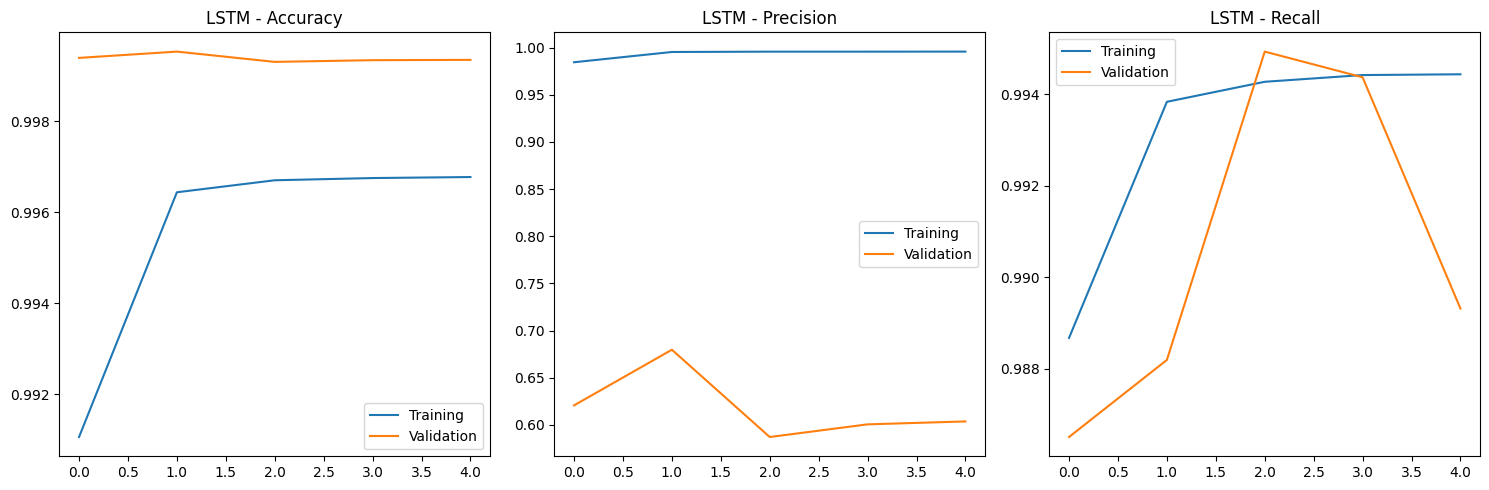


Validation Metrics - LSTM:
Accuracy: 0.9995
ROC AUC: 0.9994
PR AUC: 0.9042
Precision: 0.6797
Recall: 0.9882


In [35]:
# 3.5 Model Evaluation
print("Evaluating LSTM model...")
plot_training_history(history_lstm, "LSTM")

val_metrics_lstm = model_lstm.evaluate(X_val_seq, y_val_seq, verbose=0)
print("\nValidation Metrics - LSTM:")
print(f"Accuracy: {val_metrics_lstm[1]:.4f}")
print(f"ROC AUC: {val_metrics_lstm[2]:.4f}")
print(f"PR AUC: {val_metrics_lstm[3]:.4f}")
print(f"Precision: {val_metrics_lstm[4]:.4f}")
print(f"Recall: {val_metrics_lstm[5]:.4f}")

# Store results for later comparison
lstm_results = {
    'val_accuracy': val_metrics_lstm[1],
    'val_auc': val_metrics_lstm[2],
    'val_pr_auc': val_metrics_lstm[3],
    'val_precision': val_metrics_lstm[4],
    'val_recall': val_metrics_lstm[5],
    'model': model_lstm
}

# # Use the functions
# lstm_results = print_final_metrics_from_history(history_lstm)

##### Hybrid CNN-LSTM Model

In [ ]:

# Define the input shape
input_shape = (X_train_seq_resampled.shape[1], X_train_seq_resampled.shape[2])

# Input layer
input_layer = Input(shape=input_shape)

# CNN branch with moderate capacity and light regularization
conv1 = Conv1D(filters=56, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)  # Light regularization
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.25)(conv1)  # Reduced dropout

# Second conv layer
conv2 = Conv1D(filters=28, kernel_size=2, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv1)
conv2 = BatchNormalization()(conv2)  # Added back BatchNorm
conv2 = Dropout(0.25)(conv2)  # Reduced dropout

# LSTM branch with moderate capacity and light regularization
lstm1 = LSTM(56, return_sequences=True,
             recurrent_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
lstm1 = BatchNormalization()(lstm1)
lstm1 = Dropout(0.25)(lstm1)  # Reduced dropout

lstm2 = LSTM(28,
             recurrent_regularizer=tf.keras.regularizers.l2(0.01))(lstm1)
lstm2 = BatchNormalization()(lstm2)  # Added back BatchNorm
lstm2 = Dropout(0.25)(lstm2)  # Reduced dropout

# Merge CNN and LSTM branches
merged = Concatenate()([Flatten()(conv2), lstm2])

# Dense layer with light regularization
dense1 = Dense(28, activation='relu',  # Increased dense layer
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(merged)
dense1 = BatchNormalization()(dense1)  # Added back BatchNorm
dense1 = Dropout(0.25)(dense1)  # Reduced dropout

# Output layer
output = Dense(1, activation='sigmoid')(dense1)

# Create model
model_hybrid = Model(inputs=input_layer, outputs=output)

# 4.3 Model Compilation with balanced parameters
model_hybrid.compile(
    optimizer=Adam(learning_rate=0.002),  # More moderate learning rate
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(curve='ROC', name='auc'),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)





model_hybrid.summary()

# 4.4 Model Training
print("Training Hybrid CNN-LSTM Model...")
early_stopping_hybrid = EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=10,
    restore_best_weights=True
)

history_hybrid = model_hybrid.fit(
    X_train_seq_resampled, y_train_seq_resampled,
    epochs=3,
    batch_size=128,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping_hybrid],
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 3, 85)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 3, 56)     │      9,576 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 56)     │        224 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 3, 56)     │     31,808 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 3, 56)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 56)     │        224 │ lstm_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 28)     │      3,164 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 3, 56)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 28)     │        112 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 28)        │      9,520 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 3, 28)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28)        │        112 │ lstm_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 84)        │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 28)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 28)        │      3,164 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28)        │        112 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 28)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         29 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,045 (226.74 KB)

 Trainable params: 57,653 (225.21 KB)

 Non-trainable params: 392 (1.53 KB)

Training Hybrid CNN-LSTM Model...
Epoch 1/3
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9951 - auc: 0.9990 - loss: 0.0912 - pr_auc: 0.9983 - precision: 0.9926 - recall: 0.9927 - val_accuracy: 1.0000 - val_auc: 0.9994 - val_loss: 4.4010e-04 - val_pr_auc: 0.9937 - val_precision: 0.9736 - val_recall: 0.9955
Epoch 2/3
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0029 - pr_auc: 0.9999 - precision: 0.9999 - recall: 0.9998 - val_accuracy: 1.0000 - val_auc: 0.9989 - val_loss: 0.0091 - val_pr_auc: 0.9790 - val_precision: 0.9641 - val_recall: 0.9972
Epoch 3/3
12570/12570 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0032 - pr_auc: 1.0000 - precision: 0.9999 - recall: 0.9998 - val_accuracy: 1.0000 - val_auc: 0.9980 - val_loss: 7.2302e-04 - val_pr_auc: 0.9882 - val_precision: 0.9784 - val_recall: 0.9944


Evaluating Hybrid CNN-LSTM model...


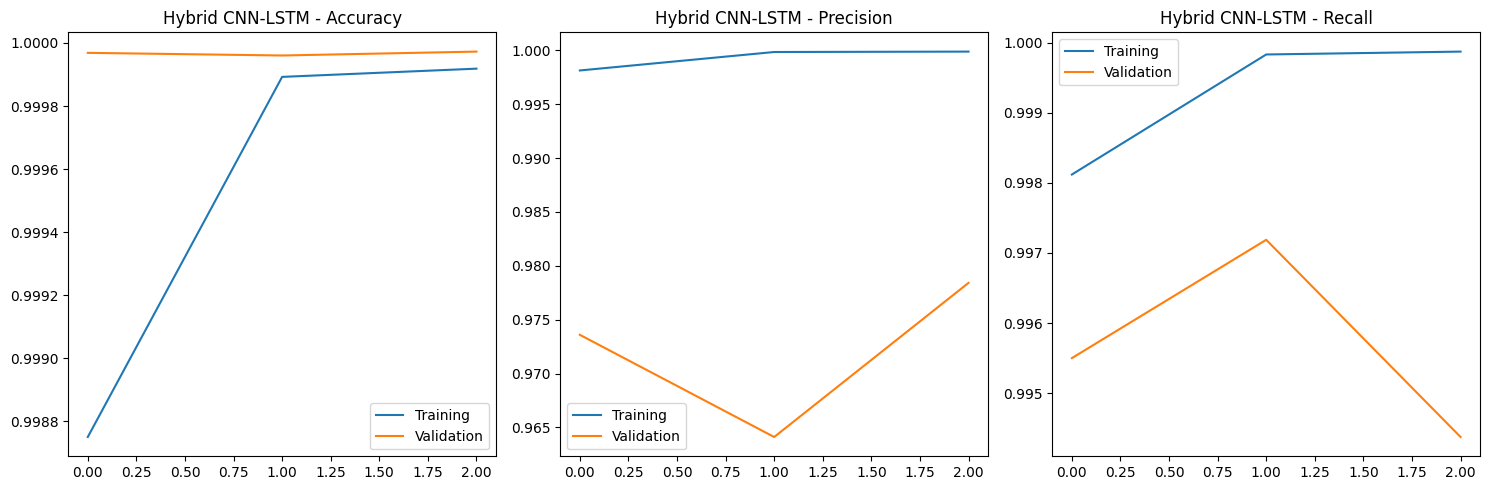


Validation Metrics - Hybrid CNN-LSTM:
Accuracy: 1.0000
ROC AUC: 0.9994
PR AUC: 0.9937
Precision: 0.9736
Recall: 0.9955


In [36]:
# 4.5 Model Evaluation
print("Evaluating Hybrid CNN-LSTM model...")
plot_training_history(history_hybrid, "Hybrid CNN-LSTM")

val_metrics_hybrid = model_hybrid.evaluate(X_val_seq, y_val_seq, verbose=0)
print("\nValidation Metrics - Hybrid CNN-LSTM:")
print(f"Accuracy: {val_metrics_hybrid[1]:.4f}")
print(f"ROC AUC: {val_metrics_hybrid[2]:.4f}")
print(f"PR AUC: {val_metrics_hybrid[3]:.4f}")
print(f"Precision: {val_metrics_hybrid[4]:.4f}")
print(f"Recall: {val_metrics_hybrid[5]:.4f}")

# Store results for later comparison
hybrid_results = {
    'val_accuracy': val_metrics_hybrid[1],
    'val_auc': val_metrics_hybrid[2],
    'val_pr_auc': val_metrics_hybrid[3],
    'val_precision': val_metrics_hybrid[4],
    'val_recall': val_metrics_hybrid[5],
    'model': model_hybrid
}

# # Use the functions
# hybrid_results = print_final_metrics_from_history(history_hybrid)

#### Model Comparison

,Validation Accuracy,Validation ROC AUC,Validation PR AUC,Validation Precision,Validation Recall
Model,,,,,
Sequential NN,0.9994,0.9858,0.8661,0.6853,0.8668
LSTM,0.9995,0.9994,0.9042,0.6797,0.9882
Hybrid CNN-LSTM,1.0000,0.9994,0.9937,0.9736,0.9955


<Figure size 1200x600 with 0 Axes>

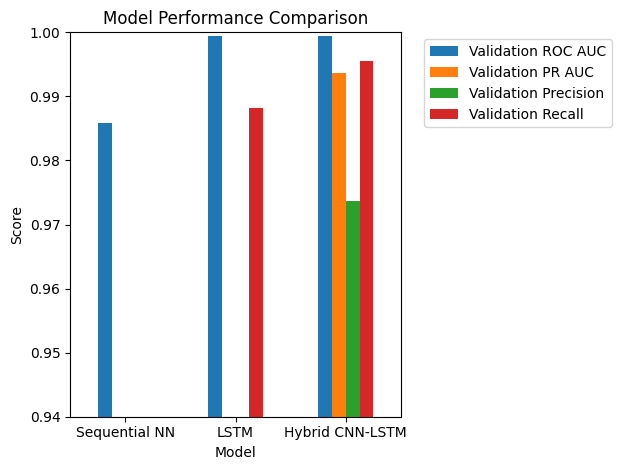


Best Model Selection:
For AML detection, recall (catching suspicious transactions) is typically prioritized
Model with highest recall: Hybrid CNN-LSTM
Model with highest PR-AUC: Hybrid CNN-LSTM

Selected model: Hybrid CNN-LSTM


In [37]:
# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': ['Sequential NN', 'LSTM', 'Hybrid CNN-LSTM'],
    'Validation Accuracy': [
        sequential_nn_results['val_accuracy'], 
        lstm_results['val_accuracy'], 
        hybrid_results['val_accuracy']
    ],
    'Validation ROC AUC': [
        sequential_nn_results['val_auc'], 
        lstm_results['val_auc'], 
        hybrid_results['val_auc']
    ],
    'Validation PR AUC': [
        sequential_nn_results['val_pr_auc'], 
        lstm_results['val_pr_auc'], 
        hybrid_results['val_pr_auc']
    ],
    'Validation Precision': [
        sequential_nn_results['val_precision'], 
        lstm_results['val_precision'], 
        hybrid_results['val_precision']
    ],
    'Validation Recall': [
        sequential_nn_results['val_recall'], 
        lstm_results['val_recall'], 
        hybrid_results['val_recall']
    ]
})

# Display comparison
display(comparison_df.set_index('Model').round(4))

# Visualize comparison
metrics = ['Validation ROC AUC', 'Validation PR AUC', 'Validation Precision', 'Validation Recall']
plt.figure(figsize=(12, 6))
comparison_df.set_index('Model')[metrics].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0.94, 1.0])  # Adjust based on your actual scores
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Select best model based on criteria
print("\nBest Model Selection:")
print("For AML detection, recall (catching suspicious transactions) is typically prioritized")
print(f"Model with highest recall: {comparison_df.loc[comparison_df['Validation Recall'].idxmax()]['Model']}")
print(f"Model with highest PR-AUC: {comparison_df.loc[comparison_df['Validation PR AUC'].idxmax()]['Model']}")

# Select the best model based on your criteria
best_model_name = "Hybrid CNN-LSTM"  # Update based on actual results
print(f"\nSelected model: {best_model_name}")

In [38]:
comparison_df

,Model,Validation Accuracy,Validation ROC AUC,Validation PR AUC,Validation Precision,Validation Recall
0,Sequential NN,0.999448,0.985848,0.866109,0.685348,0.866835
1,LSTM,0.999526,0.999367,0.904246,0.679691,0.988189
2,Hybrid CNN-LSTM,0.999969,0.999435,0.993666,0.973597,0.995501


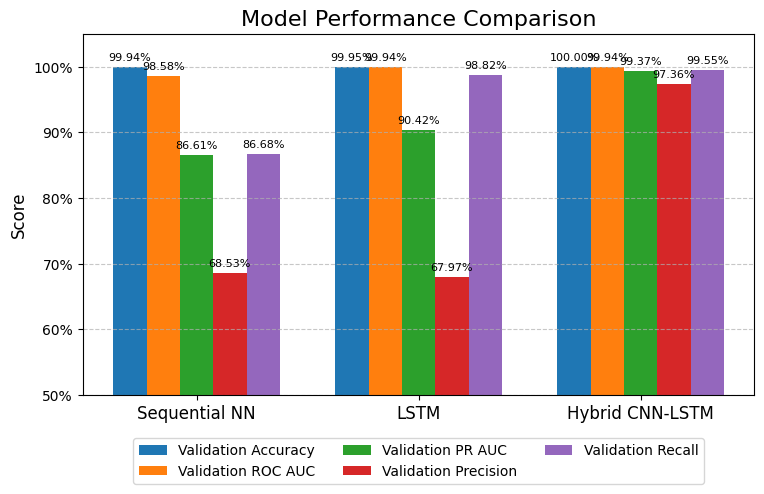

In [40]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Get the number of models and metrics
models = comparison_df['Model']
metrics = comparison_df.columns[1:]  # Skip the 'Model' column
n_models = len(models)
n_metrics = len(metrics)

# Set width of bars and positions
bar_width = 0.15
positions = np.arange(n_models)

# Create bars for each metric
for i, metric in enumerate(metrics):
    offset = (i - n_metrics/2 + 0.5) * bar_width
    bars = ax.bar(positions + offset, comparison_df[metric], 
                 width=bar_width, label=metric)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0, fontsize=8)

# Customize the plot
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(positions)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0.5, 1.05)  # Set y-axis to start at 0.8 for better visibility of differences
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  # Format as percentage
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(pad=2.0, rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for the legend
plt.show()

#### Final Model Evaluation

Finding optimal classification threshold...
55921/55921 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step
Optimal threshold: 0.9952
At this threshold - Precision: 0.9949, Recall: 0.9933, F1: 0.9941


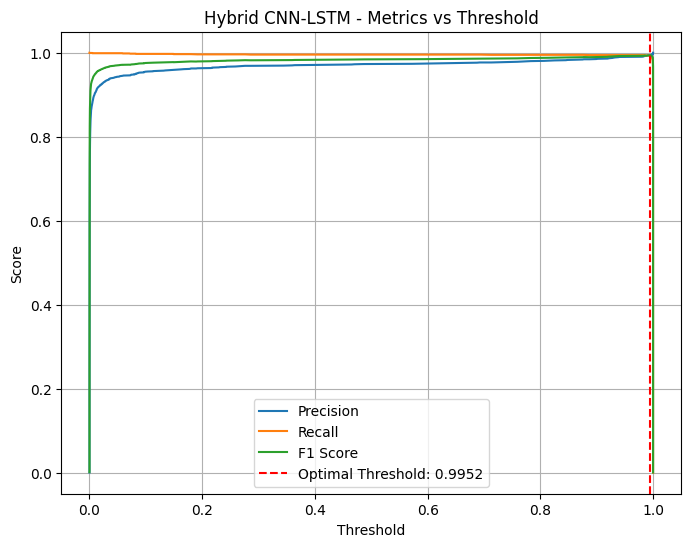


--- Final Evaluation on Test Set ---
55921/55921 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 1.0000 - auc: 0.9995 - loss: 4.3588e-04 - pr_auc: 0.9918 - precision: 0.9716 - recall: 0.9973
Test Loss: 0.0004
Test Accuracy: 1.0000
Test ROC AUC: 0.9994
Test PR AUC: 0.9931
Test Precision: 0.9752
Test Recall: 0.9966
55921/55921 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1787671
           1       0.99      0.99      0.99      1778

    accuracy                           1.00   1789449
   macro avg       1.00      0.99      1.00   1789449
weighted avg       1.00      1.00      1.00   1789449



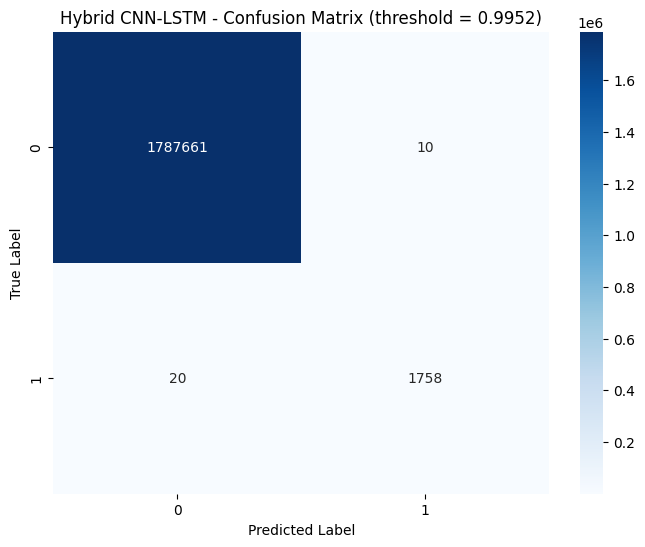

In [41]:
# Use the selected best model
if best_model_name == "Sequential NN":
    best_model = sequential_nn_results['model']
    X_test_prepared = X_test_scaled
    X_val_prepared = X_val_scaled
    y_val_prepared = y_val
    y_test_prepared = y_test
elif best_model_name == "LSTM":
    best_model = lstm_results['model']
    X_test_prepared = X_test_seq
    X_val_prepared = X_val_seq
    y_val_prepared = y_val_seq
    y_test_prepared = y_test_seq
else:  # Hybrid CNN-LSTM
    best_model = hybrid_results['model']
    X_test_prepared = X_test_seq
    X_val_prepared = X_val_seq
    y_val_prepared = y_val_seq
    y_test_prepared = y_test_seq

# Optimize threshold on validation set
print("Finding optimal classification threshold...")
y_val_pred_proba = best_model.predict(X_val_prepared)
precision, recall, thresholds = precision_recall_curve(y_val_prepared, y_val_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold - Precision: {precision[optimal_idx]:.4f}, Recall: {recall[optimal_idx]:.4f}, F1: {f1_scores[optimal_idx]:.4f}")

# Plot threshold vs metrics
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'{best_model_name} - Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Final evaluation on test set
print("\n--- Final Evaluation on Test Set ---")
test_results = best_model.evaluate(X_test_prepared, y_test_prepared, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test ROC AUC: {test_results[2]:.4f}")
print(f"Test PR AUC: {test_results[3]:.4f}")
print(f"Test Precision: {test_results[4]:.4f}")
print(f"Test Recall: {test_results[5]:.4f}")

# Get predictions with optimal threshold
y_test_pred_proba = best_model.predict(X_test_prepared)
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test_prepared, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test_prepared, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{best_model_name} - Confusion Matrix (threshold = {optimal_threshold:.4f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()